# Homework 1: Model Selection and Linear Regression

# Part 1: Model Selection

## Import Libraries

In [8]:
from time import time
import matplotlib.pyplot as plt
import numpy as np
import sys
from scipy import io
from sklearn import svm
%matplotlib inline

EMAIL_CROSSVAL_K = 6
email_training_file = "dataset/spam_data.mat"

## Question 0: Fill in the blank with code to select a good model [10pts]
In this warmup part, you should write several lines of code to find the best C for classifying spam email data.

Grading policy:
- Q0.1 [1pts]
- Q0.2 [1pts]
- Q0.3 [3pts]
- Q0.4 [5pts]

In [9]:
def timer(func):
    def func_wrapper():
        start_time = time()
        print("Start processing...")
        sys.stdout.flush()
        retval = func()
        print("Done!")
        print("Time taken: {} seconds".format(time() - start_time))
        sys.stdout.flush()
        return retval
    return func_wrapper

In [10]:
def cross_validate(training_data, training_labels, c_value, cross_validation_indices, CROSSVAL_K):
  print("Runing cross validation for C value of: {}".format(c_value))
  cross_validation_data = np.array(np.split(training_data[cross_validation_indices], CROSSVAL_K))
  cross_validation_labels = np.array(np.split(training_labels[cross_validation_indices], CROSSVAL_K))
  cross_validation_accuracy = 0.0
  for i in range(CROSSVAL_K):
    mask = np.ones(CROSSVAL_K, dtype=bool)
    mask[i] = 0
    test_set = np.concatenate(cross_validation_labels[mask])
    ### Q0.1
    ### YOUR CODE HERE - Get test labels
    test_labels = np.concatenate(cross_validation_labels[mask])
    ### END YOUR CODE

    validation_set = cross_validation_data[i]
    ### Q0.2
    ### YOUR CODE HERE - Get validation labels
    validation_labels = cross_validation_labels[i]
    ### END YOUR CODE

    linear_svm = svm.LinearSVC(C=c_value)
    linear_svm.fit(test_set, test_labels)
    validation_prediction = linear_svm.predict(validation_set)

    ### Q0.3
    ### YOUR CODE HERE - Accumulate cross validation accuracy
    cross_validation_accuracy += np.sum(validation_prediction == validation_labels)
    ### END YOUR CODE
  cross_validation_accuracy /= CROSSVAL_K
  return cross_validation_accuracy

## Perparing Data 

In [11]:
@timer
def init_email():
    global email_train_features, email_train_labels, email_test_data
    # Read and normalize email data
    email_data = io.loadmat(email_training_file)
    email_train_features = email_data['training_data']
    email_train_labels = np.ravel(np.rollaxis(email_data['training_labels'], 1, 0))
    email_test_data = email_data['test_data']
init_email()

Start processing...
Done!
Time taken: 0.015004158020019531 seconds


In [12]:
@timer
def cross_validation_email():
    max_accuracy, best_c_value = 0.0, 0.0
    c_values = np.array([10**i for i in range(-5, 10)])
    cross_validation_indices = np.arange(0, 5172)
    np.random.shuffle(cross_validation_indices)
    
    ### Q0.4
    ### YOUR CODE HERE - Write a for loop to find the best C_value AND Print all 'c_value' with the 'cross_validation_accuracy' corresponding to it
    for c_value in c_values:
        cross_validation_accuracy = cross_validate(email_train_features, email_train_labels, c_value, cross_validation_indices, EMAIL_CROSSVAL_K)
        print("C value: {}, cross validation accuracy: {}".format(c_value, cross_validation_accuracy))
        if cross_validation_accuracy > max_accuracy:
            max_accuracy = cross_validation_accuracy
            best_c_value = c_value
    ### END YOUR CODE

    return best_c_value
best_email_c_value = cross_validation_email()

Start processing...
Runing cross validation for C value of: 1e-05


ValueError: Expected 2D array, got 1D array instead:
array=[0. 0. 0. ... 1. 1. 1.].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

## Write down the best C value

### Your conclusion here
My best C value is

# Part 2: Linear Regression

In this part, we will start with utilizing Sci-Kit learn to implement a linear regression model. Afterwards, we will be dropping Sci-Kit learning and implementing these algorithms from scratch without the use of machine learning libraries. While you would likely never have to implement your own linear regression algorithm from scratch in practice, such a skill is valuable to have as you progress further into the field and find many scenarios where you actually may need to perform such implementations manually. Additionally, implementing algorithms from scratch will help you better understand the underlying mathematics behind each model.     

## Import Libraries

We will be using the following libraries for this homework assignment. For the questions requiring manual implementation, the pre-existing implementations from Sci-Kit Learn should *not* be used.

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import operator
%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error

## Preparing Data

The file named **dataset1.csv** includes data that was generated from an n-degree polynomial with some gaussian noise. The data has 2 columns - first column is the feature (input) and the second column is its label (output). The first step is to load the data and split them into training, validation, and test sets. A reminder that the purpose of each of the splitted sets are as follows:

* **Training Set**: The sample of data used to fit the model
* **Validation Set**: The sample of data used to provide an unbiased evaluation of a model fit on the training dataset while tuning model hyperparameters.
* **Test Set**: The sample of data used to provide an unbiased evaluation of a final model fit on the training dataset.

In the section below, we load the csv file and split the data randomnly into 3 equal sets. 

*Note that in practice, we usually aim for around a 70-20-10 split for train, valid, and test respectively, but due to limited data in our case, we will do an even split in order to have sufficient data for evaluation* 

In [16]:
# Load the data and split into 3 equal sets
data = pd.read_csv('dataset\dataset1.csv', header=None)
data = data.iloc[:, :-1]
train, valid, test = np.split(data, [int(.33*len(data)), int(.66*len(data))])

# We sort the data in order for plotting purposes later
train.sort_values(by=[0], inplace=True)
valid.sort_values(by=[0], inplace=True)
test.sort_values(by=[0], inplace=True)

Let's take a look at what our data looks like

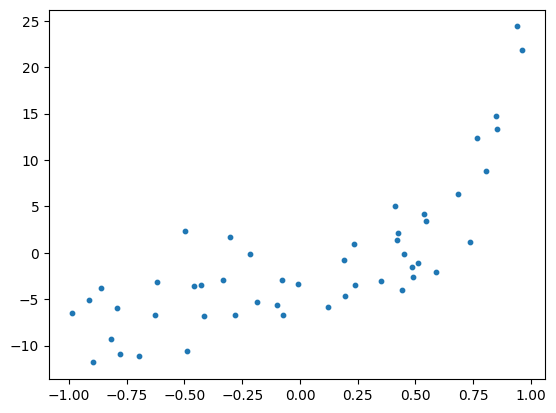

In [17]:
plt.scatter(train[0], train[1], s=10)
plt.show()

Let's apply a linear regression model using Sci-Kit learn and see what the results look like.

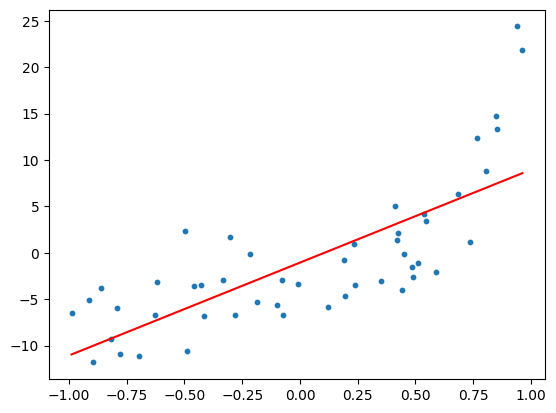

In [18]:
# Reshape arrays since sci-kit learn only takes in 2D arrays
train_x = np.array(train[0])
train_y = np.array(train[1])
valid_x = np.array(valid[0])
valid_y = np.array(valid[1])
train_x = train_x.reshape(-1, 1)
train_y = train_y.reshape(-1, 1)
valid_x = valid_x.reshape(-1, 1)
valid_y = valid_y.reshape(-1, 1)

# Apply linear regression model
model = LinearRegression()
model.fit(train_x, train_y)
y_pred = model.predict(train_x)

# Plot the results
plt.scatter(train_x, train_y, s=10)
plt.plot(train_x, y_pred, color='r')
plt.show()

By analyzing the line of best fit above, we can see that a straight line is unable to capture the patterns of the data. This is an example of underfitting. As seen in the latest lecture, we can generate a higher order equation by adding powers of the original features as new features. 

The linear model,: 

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; ** $y(x)$ = $w_1 x$ + $w_0$ ** 

can be transformed to a polynomial model such as:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; ** $y(x)$ = $w_2 x^2$ + $w_1 x$ + $w_0$ ** 

Note that this is still considered to be linear model as the coefficients/weights associated with the features are still linear. x<sup>2</sup> is only a feature. However the curve that we would be fitting in this case is quadratic in nature.

Below we show an example of a quadratic curve being fit to the data

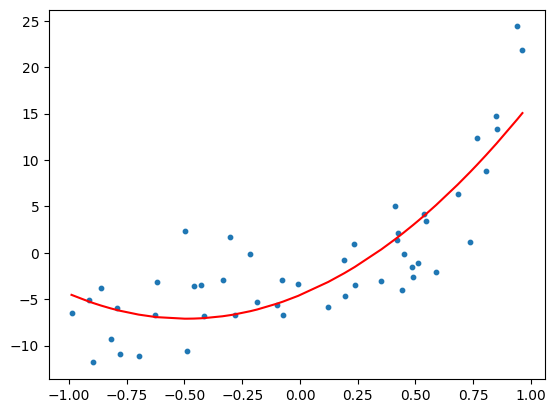

In [19]:
# Create polynomial features with degree 2
polynomial_features = PolynomialFeatures(degree=2)
x_poly = polynomial_features.fit_transform(train_x)

# Apply linear regression
model = LinearRegression()
model.fit(x_poly, train_y)
y_poly_pred = model.predict(x_poly)

# Plot the results
plt.scatter(train_x, train_y, s=10)
plt.plot(train_x, y_poly_pred, color='r')
plt.show()

As you can see, we get a slightly better fit with a quadratic curve. Let's use the model to make predictions on our validation set and compute the mean squared error, which is the error which we wish to minimize.

Mean Squared Error: 20.485214511024232


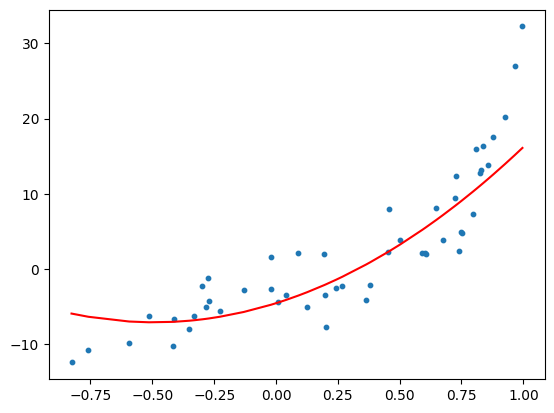

In [20]:
# Make predictions using pretrained model
valid_y_poly_pred = model.predict(polynomial_features.fit_transform(valid_x))

# Calculate mean squared error
mse = mean_squared_error(valid_y, valid_y_poly_pred)
print("Mean Squared Error: {}".format(mse))

# Plot the prediction results
plt.scatter(valid_x, valid_y, s=10)
plt.plot(valid_x, valid_y_poly_pred, color='r')
plt.show()

## Question 1: Polynomial Regression Using Sci-Kit Learn [20pts]

Now it is your turn! Following the same format as above, implement a 10-degree polynomial regression model on the training data and plot your results. Use your model to predict the output of the validation set and calculate the mean square error. Report and plot the results. 

Grading policy:

- Q1.1 [8pts]
    - Fit a 10-degree polynomial using Sci-Kit Learn [2pts]
    - Plot your the curve on the training data set [1pt]
    - Use model to predict output of validation set [2pts]
    - Calculate and report the MSE [2pt]
    - Plot the curve on the validation set [1pt]
- Q1.2 [2pts]
- Q1.3 [8pts]
    - Fit a 20-degree polynomial using Sci-Kit Learn[2pts]
    - Plot your the curve on the training data set [1pt]
    - Use model to predict output of validation set [2pts]
    - Calculate and report the MSE [2pts]
    - Plot the curve on the validation set [1pt]
- Q1.4 [2pts]

## Q1.1

In [ ]:
### YOUR CODE HERE - Fit a 10-degree polynomial using Sci-Kit Learn

### YOUR CODE HERE - Plot your the curve on the training data set

### YOUR CODE HERE - Use model to predict output of validation set

### YOUR CODE HERE - Calculate the MSE. Report and plot the curve on the validation set.

## Q1.2

#### Did the mean squared error go up or down as compared to the 2-degree polynomial curve? Why do you think this is the case?

------- ANSWER HERE -----------

Now repeat the above for a 20-degree polynomial regression model.

## Q1.3

In [ ]:
### YOUR CODE HERE - Fit a 20-degree polynomial using Sci-Kit Learn

### YOUR CODE HERE - Plot your the curve on the training data set

### YOUR CODE HERE - Use model to predict output of validation set

### YOUR CODE HERE - Calculate the RMSE. Report and plot the curve on the validation set.

## Q1.4

#### How does the mean square error compare to the previous two models? Why do you think this is the case?

-------- ANSWER HERE -----------

## Question 2: Manual Implementation [50pts]

Now it's time to appreciate the hard work that open source developers have put, in order to allow you to implemenent machine learning models without doing any math! No more Sci-Kit learn (or any other libraries like Tensorflow, Pytorch, etc) for the rest of this assignment!

Your first step is to fit a **10-degree polynomial** to the dataset we have been using above. Then using your results, calculate the mean squared error on both the training and validation set. You may use general utility libraries like numpy and pandas matrix computations and data manipulation, but pre-existing implementations of the model itself is prohibited.

A reminder that in polynomial regression, we are looking for a solution for the equation:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; ** $Y(X)$ = $W^T$ * $\phi(X)$ ** 

where

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; ** $\phi(X)$ = [ $1$, $X$, $X^2$, $X^3$, ..... $X^n$ ] **
 
and the ordinary least square solution in closed form is:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;** $W$ = $(X^T X)^{-1}X^TY$ **

Make sure to review the slides, do some research, and/or ask for clarification if this doesn't make sense. You must understand the underlying math before being able to implement this properly.

*Suggestion - Use the original pandas dataframes variables named train, valid, and test instead of the reshaped arrays that were used specifically for Sci-Kit Learn. It will make your computations cleaner and more inuitive.*

Grading policy:
- Q2.1 [15pts]
    - Create the polynomial matrix ϕ(X) [2pts]
    - Find the weighted matrix W [5pts]
    - Make predictions on the training set, calculate and report the mean squared error [2pts]
    - Plot the above results [2pts]
    - Make predictions on the validation set, calculate and report the mean squared error [2pts]
    - Plot the above results [2pts]
- Q2.2 [3pts]
    - Load dataset2.csv and split into 3 equal sets [2pts]
    - Sort the data in order for plotting purposes later [1pt]
- Q2.3 [2pts]
- Q2.4 [30pts]
    - Implement gradient decent [25pts]
        - Correctness of the gradient [10pts]
        - Correctness of the update in each iteration [10pts]
        - Convergence of the algorithm [5pts]
    - Calculate and report the mean squared error on both training and validation set [3pts]
    - Plot the above results [2pts]

## Q2.1

In [ ]:
### YOUR CODE HERE - Create the polynomial matrix ϕ(X)

### YOUR CODE HERE - Find the weighted matrix W

### YOUR CODE HERE - Make predictions on the training set and calculate the mean squared error. Plot the results.

### YOUR CODE HERE - Make predictions on the validation set and calculate the mean squared error. Plot the results.

For the rest of the assignment, we will use the other dataset named **dataset2.csv**. First load the csv and split the model into train, valid, and test sets as shown earlier in the assignment.

## Q2.2

In [ ]:
### YOUR CODE HERE - Load dataset2.csv and split into 3 equal sets

### YOUR CODE HERE - Sort the data in order for plotting purposes later


Plot the data below to see what it looks like

## Q2.3

In [ ]:
### YOUR CODE HERE - Plot the points for dataset2


If done properly, you should see that the points fall under a relatively straight line with minor deviations. Looks like a perfect example to implement a linear regression model using the **gradient descent** method ..... without the use of any machine learning libraries!

Since the data falls along a straight line, we can assume the solution follows the form:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; ** $y(x)$ = $m x$ + $b$ **

A reminder that in gradient descent, we essentially want to iteratively get closer to the minimum of our objective function (the mean squared error), such that:
 
 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; ** MSE($w_0$) > MSE($w_1$) > MSE($w_2$) > ...**

The algorithm is as follows:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; ** 1) Pick initial $w_0$ randomnly. **

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; ** 2) For $k=1,2..$ $\Rightarrow$ $w_{k+1}$ = $w_k$ - $\alpha$  $g(w_k)$  where $\alpha > 0$ is the learning rate and $g(w_k)$ is the gradient. **

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; ** End when | $w_k$ + $1$ - $w_k$ | < $\epsilon$ **


There are many resources online for gradient descent. You must understand the underlying math before being able to implement this properly.

Now once you understand, it is time to implement the gradient descent below. You may set the learning rate to 1e-6 or whatever value you think is best. As usual, calculate the mean squared error and plot your results. This time, training should be done using the training and validation sets, while the final mean squared error should be computed using the testing set.

## Q2.4

In [ ]:
### YOUR CODE HERE - Implement gradient decent

### YOUR CODE HERE - Calculate the mean squared error on both training and validation set and plot the results.